In [6]:
from pypower.api import loadcase, runopf, ppoption
from pypower.idx_brch import *
from pypower.idx_bus import *
import oct2py
import numpy as np
import os
from tqdm import tqdm
from oct2py import Oct2Py
octave = Oct2Py()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import pickle
import shutil
if shutil.which('latex') is None:
    LATEX_AVAILABLE = False
else:
    LATEX_AVAILABLE = True
if LATEX_AVAILABLE:
    plt.rcParams['font.size'] = 14
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
    
MAX_BUS = 10000 # upper limit of number of buses in cases to be considered

Loaded pglib_opf_case793_goc.m: 100%|██████████████████████████████████████████████████████████████████████████| 66/66 [00:58<00:00,  1.12it/s]


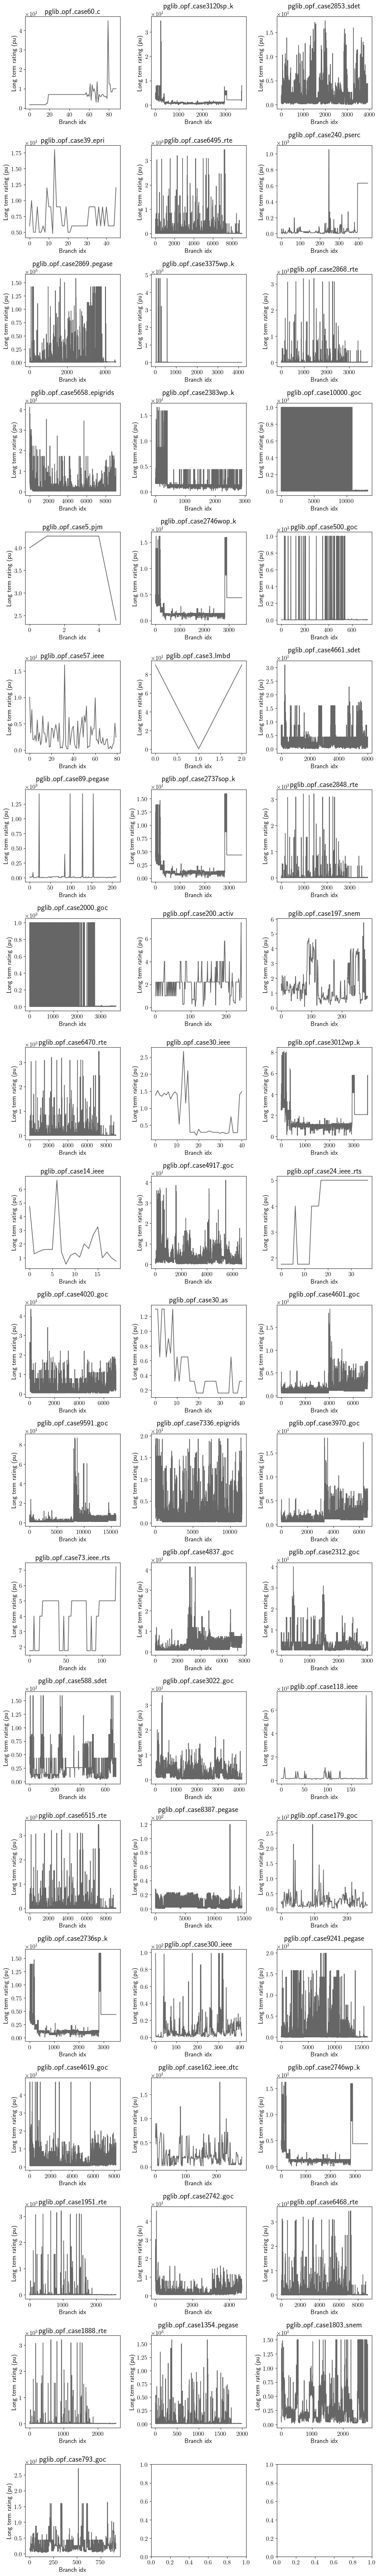

In [7]:
# get all cases in current directory
current_directory = os.getcwd()
all_files_and_directories = os.listdir(current_directory)
case_files = [os.path.join(current_directory, f) for f in all_files_and_directories if f.endswith('.m') and os.path.isfile(os.path.join(current_directory, f))]

cases, casenames = [], []
for cf in (t:=tqdm(case_files)):
    octave.source(os.path.basename(cf))
    cname = os.path.basename(cf).split('.')[0]
    num_buses = None
    for ci in cname.split('_'):
        if 'case' in ci:
            num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
    if num_buses <= MAX_BUS:
        cases.append(loadcase(octave.feval(cname)))
        casenames.append(cname)
    t.set_description(f"Loaded {os.path.basename(cf)}")
    
# carry out some tests to charachterize
# rate limits
n = len(cases)
ncols = 3
nrows = n // ncols + (n % ncols > 0)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
axs = axs.flatten()
for cname,c,ax in zip(casenames,cases,axs[:len(casenames)]):
    ax.plot(c['branch'][:,RATE_A] / c['baseMVA'],'k',linewidth=1.5,alpha=0.6)
    ax.set_title(cname)
    ax.set_xlabel('Branch idx')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylabel('Long term rating (pu)')
plt.tight_layout()
plt.savefig(f'brch_lims_maxbus_{MAX_BUS}.pdf',format='pdf',bbox_inches='tight')
plt.show()

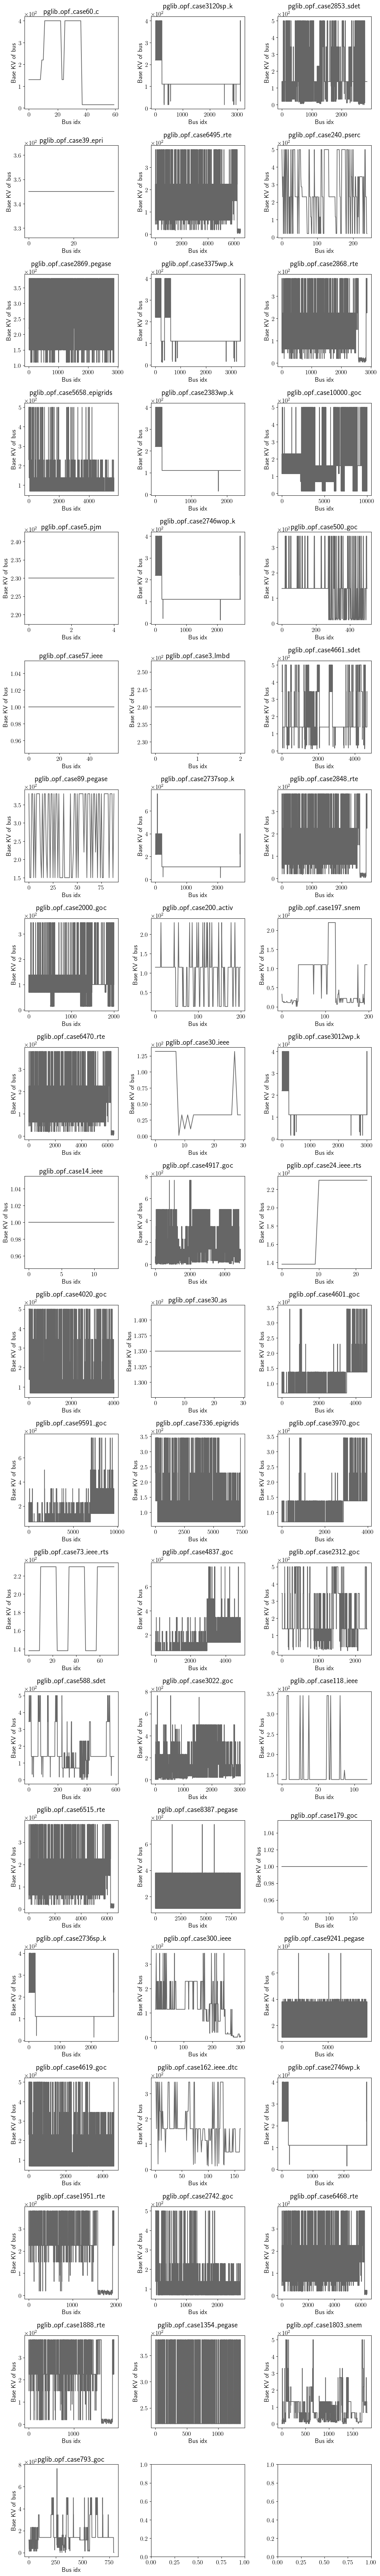

In [8]:
# rate limits
n = len(cases)
ncols = 3
nrows = n // ncols + (n % ncols > 0)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
axs = axs.flatten()
for cname,c,ax in zip(casenames,cases,axs[:len(casenames)]):
    ax.plot(c['bus'][:,BASE_KV],'k',linewidth=1.5,alpha=0.6)
    ax.set_title(cname)
    ax.set_xlabel('Bus idx')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylabel('Base KV of bus')
plt.tight_layout()
plt.savefig(f'bus_basekv_maxbus_{MAX_BUS}.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [9]:
# import networkx as nx
# from_nodes = cases[0]['branch'][:,F_BUS]
# to_nodes = cases[0]['branch'][:,T_BUS]
# G = nx.DiGraph()
# for f, t in zip(from_nodes, to_nodes):
#     G.add_edge(f, t)
# layout = nx.spectral_layout(G)
# nx.draw(G, pos=layout, node_color='lightblue', edge_color='gray', node_size=50, font_weight='bold')

# # Show the plot
# plt.show()

# graphs
# n = len(cases)
# ncols = 3
# nrows = n // ncols + (n % ncols > 0)
# fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
# axs = axs.flatten()
# for cname,c,ax in (tq:=tqdm(zip(casenames,cases,axs[:len(casenames)]))):
#     from_nodes = c['branch'][:,F_BUS]
#     to_nodes = c['branch'][:,T_BUS]
#     G = nx.DiGraph()
#     for f, t in zip(from_nodes, to_nodes):
#         G.add_edge(f, t)
#     layout = nx.spectral_layout(G)
#     nx.draw(G, ax=ax, pos=layout, node_color='lightblue', edge_color='gray', node_size=50, font_weight='bold')
#     ax.set_title(cname)
#     tq.set_description(f"Plotted {cname}.")
# plt.tight_layout()
# plt.savefig(f'grid_graph_maxbus_{MAX_BUS}.pdf',format='pdf',bbox_inches='tight')
# plt.show()

In [10]:
# solve the cases and dumpt the json file

results = []
for cn,case in (t:=tqdm(zip(casenames,cases))):
    res = runopf(case,ppopt=ppoption(opt=None,VERBOSE=0,OUT_ALL=0))
    t.set_description(f"Solved case {cn}.")
    results.append(res)
    with open(os.getcwd()+f'/{cn}_solved.pkl','wb') as pf:
        pickle.dump(res,pf)

Solved case pglib_opf_case793_goc.: : 58it [3:38:48, 226.35s/it]      
